<a href="https://colab.research.google.com/github/giangdip2410/Research-Stuff/blob/main/CPSC5440_Assigment5_JGM667.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction to GAN**

**In this notebook, I will experiment various types of GAN model with PyTorch which benchmark on CIFAR-10 dataset. The models will be able to generate new image after training on the dataset. Datasets available at: https://paperswithcode.com/sota/image-generation-on-cifar-10**

### Library 

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from multiprocessing import Pool
cudnn.benchmark = True
from torchsummary import summary
import pickle
import pandas as pd
import time
import random

In [ ]:
#fix seed for stable training
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Config

In [ ]:
learning_rate = 0.0002
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epoch = 30
n_critic = 4
batch_size = 32
num_workers = 2
img_size = 32 * 32 * 3
latent_dim = 100

### Data Preporcessing

In [ ]:
# simple transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#dataset
train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
training_data  = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= num_workers)
test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
testing_data  = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)
# classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


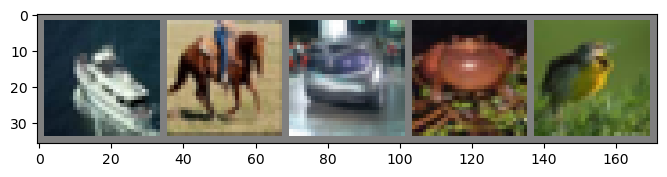

 ship              horse                car               frog               bird


In [ ]:
# show sample image
def imshow(img):
    plt.figure(figsize=(8, 16))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(training_data)
images, labels = next(iter(training_data))

# show images
num_show = 5
imshow(make_grid(images[:num_show]))
# print labels
print('              '.join('%5s' % classes[labels[j]] for j in range(num_show)))

### Model 1: GAN-MLP

#### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=img_size):
        super(Discriminator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.mlp(x)
        return x

#### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=latent_dim,  output_size=img_size):
        super(Generator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, output_size)
        )
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.mlp(x)
        return x

#### Optimization

In [ ]:
#model
D = Discriminator().to(device)
G = Generator().to(device)
#loss funcgion
criterion = nn.BCEWithLogitsLoss()
#optimization
opt_g = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

#### Training function

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def training(D, G, criterion, opt_d, opt_g, latent_dim, training_data, n_epoch, n_critic, freq_save=5, model_type='MLP'):
    for epoch in tqdm(range(1, n_epoch + 1)):
        # put train mode
        G.train()
        D.train()
        start_time = time.monotonic()
        for real_x, _ in training_data:
            real_x = real_x.to(device)
            batch = real_x.size(0)
            #label for real/fake
            if model_type == 'MLP':
                flag_real = torch.ones([batch, 1],  dtype=torch.float64).to(device)
                flag_fake = torch.zeros([batch, 1],  dtype=torch.float64).to(device)
            elif model_type == 'CNN':
                flag_real = torch.ones([batch],  dtype=torch.float64).to(device)
                flag_fake = torch.zeros([batch],  dtype=torch.float64).to(device)
            # training D
            for _ in range(n_critic):
                D.zero_grad()
                if model_type == 'MLP':
                    z = torch.randn(batch, latent_dim).to(device)
                elif model_type == 'CNN':
                    z = torch.randn(batch, latent_dim, 1, 1).to(device)
                #generate image
                fake_x = G(z)
                # output real
                out_real = D(real_x)
                out_fake = D(fake_x)
                # loss real and fake
                loss_real = criterion(out_real, flag_real)
                loss_fake = criterion(out_fake, flag_fake)
                # discriminator loss 
                t_loss = loss_real + loss_fake
                t_loss.backward()
                #update weights D
                opt_d.step()
            # training G
            G.zero_grad()
            # start with noise
            if model_type == 'MLP':
                z = torch.randn(batch, latent_dim).to(device)
            elif model_type == 'CNN':
                z = torch.randn(batch, latent_dim, 1, 1).to(device)
            # z = torch.randn(batch, latent_dim).to(device)
            # fake images
            fake_x = G(z)
            # predict for fake images
            out_gen = D(fake_x)
            # gen loss
            gen_loss = criterion(out_gen, flag_real)
            gen_loss.backward()
            # update weights G
            opt_g.step()
        end_time = time.monotonic()
        #log loss
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tDiscriminator Loss: {t_loss.item():.3f} ')
        print(f'\tGenerator Loss: {gen_loss.item():.3f} ')
        #save weights
        if (epoch % freq_save == 0) or (epoch == 1):
            gen_img = fake_x.detach().cpu()
            gen_img = gen_img.reshape(-1, 3, 32, 32)
            imshow(make_grid(gen_img[:5]))
            torch.save(G.state_dict(), f"{model_type}_G_%04d.pt" % epoch)
            torch.save(D.state_dict(), f"{model_type}_D_%04d.pt" % epoch)

  0%|          | 0/30 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 01 | Epoch Time: 0m 28s
	Discriminator Loss: 0.008 
	Generator Loss: 6.124 


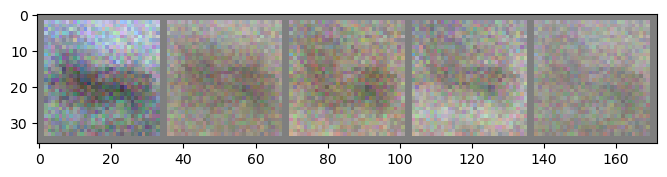

Epoch: 02 | Epoch Time: 0m 29s
	Discriminator Loss: 0.011 
	Generator Loss: 6.455 
Epoch: 03 | Epoch Time: 0m 27s
	Discriminator Loss: 0.004 
	Generator Loss: 5.924 
Epoch: 04 | Epoch Time: 0m 23s
	Discriminator Loss: 0.030 
	Generator Loss: 7.780 
Epoch: 05 | Epoch Time: 0m 26s
	Discriminator Loss: 0.135 
	Generator Loss: 4.733 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 06 | Epoch Time: 0m 25s
	Discriminator Loss: 0.059 
	Generator Loss: 4.474 


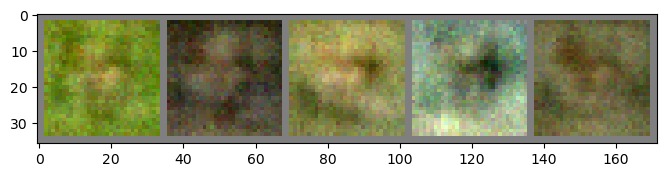

Epoch: 07 | Epoch Time: 0m 27s
	Discriminator Loss: 0.089 
	Generator Loss: 5.345 
Epoch: 08 | Epoch Time: 0m 24s
	Discriminator Loss: 0.070 
	Generator Loss: 4.423 
Epoch: 09 | Epoch Time: 0m 27s
	Discriminator Loss: 0.222 
	Generator Loss: 3.542 
Epoch: 10 | Epoch Time: 0m 26s
	Discriminator Loss: 0.276 
	Generator Loss: 3.533 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11 | Epoch Time: 0m 27s
	Discriminator Loss: 0.204 
	Generator Loss: 2.726 


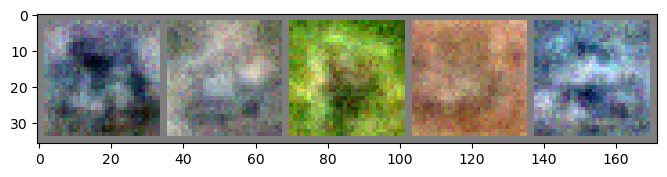

Epoch: 12 | Epoch Time: 0m 27s
	Discriminator Loss: 0.169 
	Generator Loss: 3.144 
Epoch: 13 | Epoch Time: 0m 26s
	Discriminator Loss: 0.383 
	Generator Loss: 1.990 
Epoch: 14 | Epoch Time: 0m 26s
	Discriminator Loss: 0.186 
	Generator Loss: 2.276 
Epoch: 15 | Epoch Time: 0m 28s
	Discriminator Loss: 0.187 
	Generator Loss: 2.740 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 16 | Epoch Time: 0m 28s
	Discriminator Loss: 0.395 
	Generator Loss: 2.919 


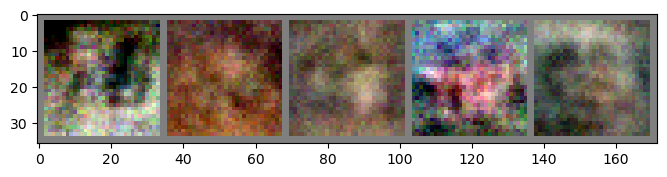

Epoch: 17 | Epoch Time: 0m 22s
	Discriminator Loss: 0.483 
	Generator Loss: 2.390 
Epoch: 18 | Epoch Time: 0m 29s
	Discriminator Loss: 0.288 
	Generator Loss: 2.797 
Epoch: 19 | Epoch Time: 0m 28s
	Discriminator Loss: 0.246 
	Generator Loss: 2.814 
Epoch: 20 | Epoch Time: 0m 27s
	Discriminator Loss: 0.176 
	Generator Loss: 2.237 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 21 | Epoch Time: 0m 23s
	Discriminator Loss: 0.430 
	Generator Loss: 2.027 


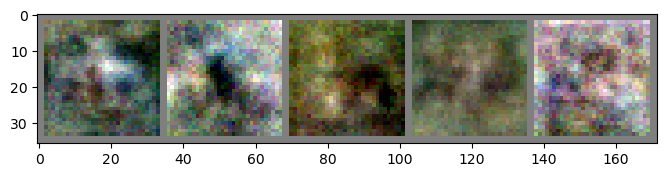

Epoch: 22 | Epoch Time: 0m 28s
	Discriminator Loss: 0.589 
	Generator Loss: 2.444 
Epoch: 23 | Epoch Time: 0m 23s
	Discriminator Loss: 0.602 
	Generator Loss: 2.414 
Epoch: 24 | Epoch Time: 0m 25s
	Discriminator Loss: 0.381 
	Generator Loss: 3.128 
Epoch: 25 | Epoch Time: 0m 28s
	Discriminator Loss: 0.250 
	Generator Loss: 1.678 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 26 | Epoch Time: 0m 21s
	Discriminator Loss: 0.176 
	Generator Loss: 2.426 


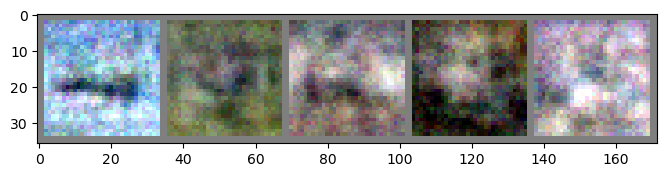

Epoch: 27 | Epoch Time: 0m 28s
	Discriminator Loss: 0.271 
	Generator Loss: 2.696 
Epoch: 28 | Epoch Time: 0m 30s
	Discriminator Loss: 0.710 
	Generator Loss: 2.058 
Epoch: 29 | Epoch Time: 0m 23s
	Discriminator Loss: 0.305 
	Generator Loss: 2.039 
Epoch: 30 | Epoch Time: 0m 27s
	Discriminator Loss: 0.375 
	Generator Loss: 2.080 


In [ ]:
#start training
training(D, G, criterion, opt_d, opt_g, latent_dim, training_data, n_epoch, n_critic)

### Predict function

In [ ]:
def generate_img(G, latent_dim, device, number_img=100):
    #random z
    z = torch.randn(number_img, latent_dim).to(device)
    # fake images
    fake_x = G(z)
    gen_img = fake_x.detach().cpu()
    gen_img = gen_img.reshape(-1, 3, 32, 32)
    return gen_img

In [ ]:
#load model generating
G.load_state_dict(torch.load("MLP_G_0026.pt"))
gen_img = generate_img(G, latent_dim, device, number_img=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


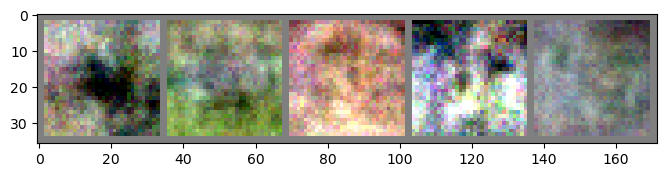

In [ ]:
#visualize generate image
num_show = 5
imshow(make_grid(gen_img[:num_show]))

### Model 2: Deep Convolutional GAN (DC-GAN)

#### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=3, img_size=32):
        super(Discriminator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        features = 32
        self.model.add_module("Conv_first", nn.Conv2d(in_ch, features, 4, 2, 1, bias=True))
        self.model.add_module("Act_first", nn.LeakyReLU(negative_slope=0.2))
        in_features = features
        for i in range(n_layer):
            out_features = features * 2
            self.model.add_module('Conv%d' % i, nn.Conv2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.LeakyReLU(negative_slope=0.2))
            in_features = out_features
        # last layer
        self.model.add_module('Conv_last', nn.Conv2d(in_features, 1, 2, 1, bias=True))
        self.weight_init()
    def weight_init(self):
        for m in self.model:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()
    def forward(self, x):
        return self.model(x).view(-1)

#### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, out_ch=3, img_size=32):
        super(Generator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        
        features = 512
        self.model.add_module('Deconv_first', nn.ConvTranspose2d(latent_dim, features, 2,  2, bias=True))
        self.model.add_module('BN_first', nn.BatchNorm2d(features))
        self.model.add_module('Act_first', nn.ReLU(inplace=True))
        in_features = features
        for i in range(n_layer):
            out_features= in_features // 2
            self.model.add_module('Deconv%d' % i, nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.ReLU(inplace=True))
            in_features = out_features
        #last layer
        self.model.add_module('Deconv_last', nn.ConvTranspose2d(in_features, out_ch, 2, 2, bias=True))
        self.model.add_module('Act_last', nn.Tanh())
        self.weight_init()
    def weight_init(self):
        for m in self.model:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()
    
    def forward(self, z):
        return self.model(z)

#### Training 

In [ ]:
#model
D = Discriminator().to(device)
G = Generator().to(device)
#loss funcgion
criterion = nn.BCEWithLogitsLoss()
#optimization
opt_g = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Discriminator Loss: 1.538 
	Generator Loss: 1.736 


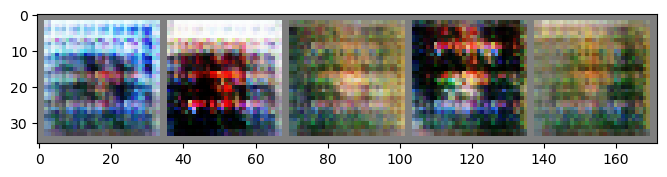

Epoch: 02 | Epoch Time: 0m 25s
	Discriminator Loss: 0.786 
	Generator Loss: 2.399 
Epoch: 03 | Epoch Time: 0m 26s
	Discriminator Loss: 0.333 
	Generator Loss: 3.380 
Epoch: 04 | Epoch Time: 0m 26s
	Discriminator Loss: 0.914 
	Generator Loss: 2.792 
Epoch: 05 | Epoch Time: 0m 25s
	Discriminator Loss: 0.484 
	Generator Loss: 2.795 


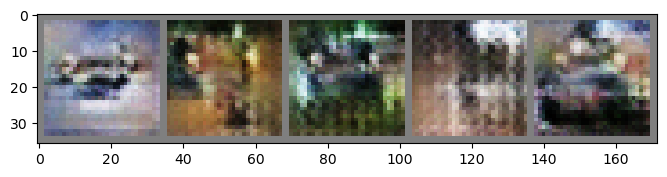

Epoch: 06 | Epoch Time: 0m 28s
	Discriminator Loss: 0.355 
	Generator Loss: 2.292 
Epoch: 07 | Epoch Time: 0m 28s
	Discriminator Loss: 0.486 
	Generator Loss: 2.829 
Epoch: 08 | Epoch Time: 0m 24s
	Discriminator Loss: 0.918 
	Generator Loss: 3.041 
Epoch: 09 | Epoch Time: 0m 26s
	Discriminator Loss: 1.595 
	Generator Loss: 2.786 
Epoch: 10 | Epoch Time: 0m 26s
	Discriminator Loss: 1.277 
	Generator Loss: 1.260 


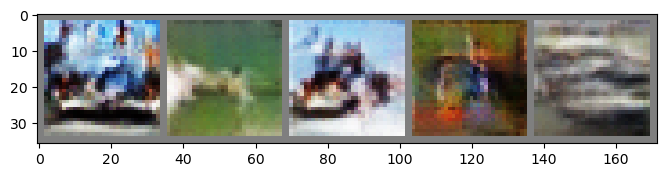

Epoch: 11 | Epoch Time: 0m 25s
	Discriminator Loss: 0.260 
	Generator Loss: 4.352 
Epoch: 12 | Epoch Time: 0m 22s
	Discriminator Loss: 0.855 
	Generator Loss: 0.963 
Epoch: 13 | Epoch Time: 0m 25s
	Discriminator Loss: 0.430 
	Generator Loss: 4.613 
Epoch: 14 | Epoch Time: 0m 19s
	Discriminator Loss: 0.197 
	Generator Loss: 4.480 
Epoch: 15 | Epoch Time: 0m 23s
	Discriminator Loss: 0.242 
	Generator Loss: 3.336 


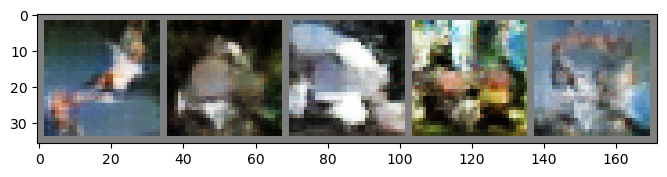

Epoch: 16 | Epoch Time: 0m 25s
	Discriminator Loss: 0.894 
	Generator Loss: 2.684 
Epoch: 17 | Epoch Time: 0m 27s
	Discriminator Loss: 1.070 
	Generator Loss: 5.525 
Epoch: 18 | Epoch Time: 0m 25s
	Discriminator Loss: 0.422 
	Generator Loss: 1.627 
Epoch: 19 | Epoch Time: 0m 26s
	Discriminator Loss: 0.655 
	Generator Loss: 3.276 
Epoch: 20 | Epoch Time: 0m 28s
	Discriminator Loss: 1.469 
	Generator Loss: 0.255 


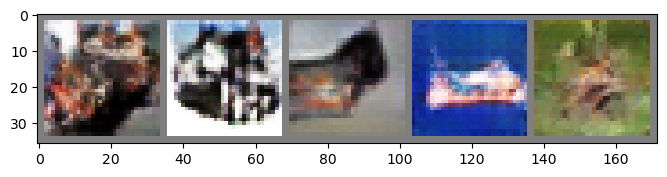

In [ ]:
#start training
training(D, G, criterion, opt_d, opt_g, latent_dim, training_data, n_epoch, n_critic=20, model_type='CNN')

#### Predict

In [ ]:
def generate_img(G, latent_dim, device, number_img=100, model_type='CNN'):
    #random z
    if model_type == 'MLP':
        z = torch.randn(number_img, latent_dim).to(device)
    elif model_type == 'CNN':
        z = torch.randn(number_img, latent_dim, 1, 1).to(device)
    # fake images
    fake_x = G(z)
    gen_img = fake_x.detach().cpu()
    gen_img = gen_img.reshape(-1, 3, 32, 32)
    return gen_img

In [ ]:
#load model generating
G.load_state_dict(torch.load("CNN_G_0020.pt"))
gen_img = generate_img(G, latent_dim, device, number_img=100, model_type='CNN')

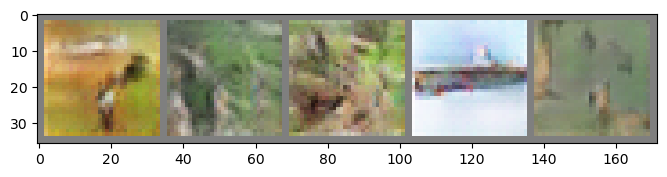

In [ ]:
#visualize generate image
num_show = 5
imshow(make_grid(gen_img[:num_show]))

**Comparing with MLP-GAN, DC-GAN show better loss results after 20 epochs. As a result, generating images show better images with more detail about color and object.**

### Conditional DC-GAN

#### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=3, num_class=10, img_size=32):
        super(Discriminator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        features = 32
        self.model.add_module("Conv_first", nn.Conv2d(in_ch+num_class, features, 4, 2, 1, bias=True))
        self.model.add_module("Act_first", nn.LeakyReLU(negative_slope=0.2))
        in_features = features
        for i in range(n_layer):
            out_features = features * 2
            self.model.add_module('Conv%d' % i, nn.Conv2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.LeakyReLU(negative_slope=0.2))
            in_features = out_features
        # last layer
        self.model.add_module('Conv_last', nn.Conv2d(in_features, 1, 2, 1, bias=True))
        self.weight_init()
    def weight_init(self):
        for m in self.model:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()
    def forward(self, x):
        return self.model(x).view(-1)

#### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_class=10, out_ch=3, img_size=32):
        super(Generator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        
        features = 512
        self.model.add_module('Deconv_first', nn.ConvTranspose2d(latent_dim+num_class, features, 2,  2, bias=True))
        self.model.add_module('BN_first', nn.BatchNorm2d(features))
        self.model.add_module('Act_first', nn.ReLU(inplace=True))
        in_features = features
        for i in range(n_layer):
            out_features= in_features // 2
            self.model.add_module('Deconv%d' % i, nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.ReLU(inplace=True))
            in_features = out_features
        #last layer
        self.model.add_module('Deconv_last', nn.ConvTranspose2d(in_features, out_ch, 2, 2, bias=True))
        self.model.add_module('Act_last', nn.Tanh())
        self.weight_init()
    def weight_init(self):
        for m in self.model:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.zero_()
    
    def forward(self, z):
        return self.model(z)

In [ ]:
#model
D = Discriminator().to(device)
G = Generator().to(device)
#loss funcgion
criterion = nn.BCEWithLogitsLoss()
#optimization
opt_g = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
def training_condition(D, G, criterion, opt_d, opt_g, latent_dim, training_data, n_epoch, n_critic, freq_save=5, num_class=10, model_type='CNN'):
    for epoch in tqdm(range(1, n_epoch + 1)):
        # put train mode
        G.train()
        D.train()
        start_time = time.monotonic()
        for real_x, y in training_data:
            real_x = real_x.to(device)
            #one hot
            onehot = torch.eye(num_class)[y].to(device)[:, :, None, None]
            batch = real_x.size(0)
            onehot_expand = onehot.expand(batch, onehot.size(1), real_x.size(2), real_x.size(3))
            #label for real/fake
            if model_type == 'MLP':
                flag_real = torch.ones([batch, 1],  dtype=torch.float64).to(device)
                flag_fake = torch.zeros([batch, 1],  dtype=torch.float64).to(device)
            elif model_type == 'CNN':
                flag_real = torch.ones([batch],  dtype=torch.float64).to(device)
                flag_fake = torch.zeros([batch],  dtype=torch.float64).to(device)
            # training D
            for _ in range(n_critic):
                D.zero_grad()
                if model_type == 'MLP':
                    z = torch.randn(batch, latent_dim+num_class).to(device)
                elif model_type == 'CNN':
                    z = torch.randn(batch, latent_dim+num_class, 1, 1).to(device)
                #generate image
                z[:, :num_class] = onehot
                fake_x = G(z)
                _real_x =  torch.cat((real_x, onehot_expand), dim=1)
                _fake_x = torch.cat((fake_x, onehot_expand), dim=1)
                # output real
                out_real = D(_real_x)
                out_fake = D(_fake_x)
                # loss real and fake
                loss_real = criterion(out_real, flag_real)
                loss_fake = criterion(out_fake, flag_fake)
                # discriminator loss 
                t_loss = loss_real + loss_fake
                t_loss.backward()
                #update weights D
                opt_d.step()
            # training G
            G.zero_grad()
            # start with noise
            if model_type == 'MLP':
                z = torch.randn(batch, latent_dim+num_class).to(device)
            elif model_type == 'CNN':
                z = torch.randn(batch, latent_dim+num_class, 1, 1).to(device)
            # z = torch.randn(batch, latent_dim).to(device)
            # fake images
            z[:, :num_class] = onehot
            fake_x = G(z)
            _fake_x = torch.cat((fake_x, onehot_expand), dim=1)
            # predict for fake images
            out_gen = D(_fake_x)
            # gen loss
            gen_loss = criterion(out_gen, flag_real)
            gen_loss.backward()
            # update weights G
            opt_g.step()
        end_time = time.monotonic()
        #log loss
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tDiscriminator Loss: {t_loss.item():.3f} ')
        print(f'\tGenerator Loss: {gen_loss.item():.3f} ')
        #save weights
        if (epoch % freq_save == 0) or (epoch == 1):
            gen_img = fake_x.detach().cpu()
            gen_img = gen_img.reshape(-1, 3, 32, 32)
            imshow(make_grid(gen_img[:5]))
            torch.save(G.state_dict(), f"{model_type}_Condition_G_%04d.pt" % epoch)
            torch.save(D.state_dict(), f"{model_type}_Condition_D_%04d.pt" % epoch)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 17s
	Discriminator Loss: 0.987 
	Generator Loss: 1.286 


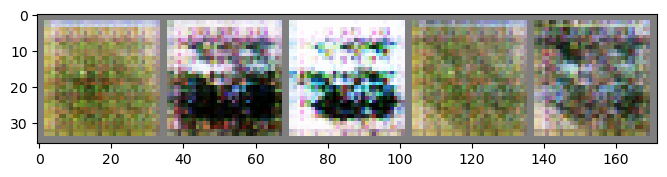

Epoch: 02 | Epoch Time: 0m 23s
	Discriminator Loss: 0.832 
	Generator Loss: 1.379 
Epoch: 03 | Epoch Time: 0m 21s
	Discriminator Loss: 0.934 
	Generator Loss: 1.484 
Epoch: 04 | Epoch Time: 0m 22s
	Discriminator Loss: 1.282 
	Generator Loss: 1.732 
Epoch: 05 | Epoch Time: 0m 19s
	Discriminator Loss: 1.676 
	Generator Loss: 0.329 


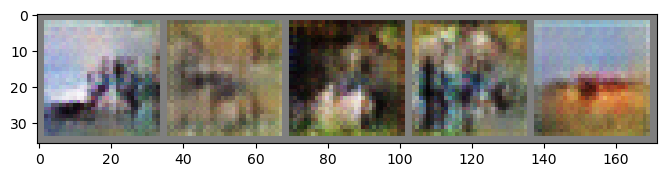

Epoch: 06 | Epoch Time: 0m 19s
	Discriminator Loss: 1.201 
	Generator Loss: 1.208 
Epoch: 07 | Epoch Time: 0m 18s
	Discriminator Loss: 1.406 
	Generator Loss: 1.425 
Epoch: 08 | Epoch Time: 0m 23s
	Discriminator Loss: 1.152 
	Generator Loss: 0.310 
Epoch: 09 | Epoch Time: 0m 21s
	Discriminator Loss: 1.408 
	Generator Loss: 0.653 
Epoch: 10 | Epoch Time: 0m 23s
	Discriminator Loss: 1.517 
	Generator Loss: 1.170 


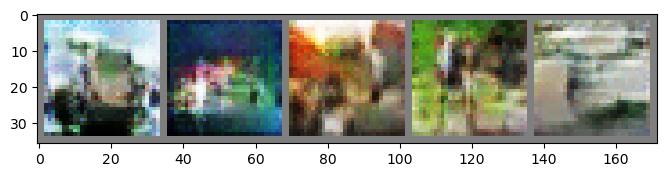

Epoch: 11 | Epoch Time: 0m 22s
	Discriminator Loss: 0.981 
	Generator Loss: 0.902 
Epoch: 12 | Epoch Time: 0m 22s
	Discriminator Loss: 0.657 
	Generator Loss: 1.078 
Epoch: 13 | Epoch Time: 0m 21s
	Discriminator Loss: 0.721 
	Generator Loss: 1.249 
Epoch: 14 | Epoch Time: 0m 19s
	Discriminator Loss: 0.763 
	Generator Loss: 1.310 
Epoch: 15 | Epoch Time: 0m 19s
	Discriminator Loss: 1.750 
	Generator Loss: 1.223 


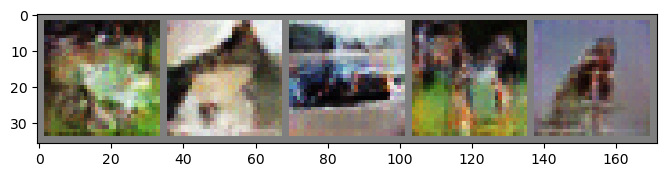

Epoch: 16 | Epoch Time: 0m 20s
	Discriminator Loss: 1.497 
	Generator Loss: 2.186 
Epoch: 17 | Epoch Time: 0m 22s
	Discriminator Loss: 0.802 
	Generator Loss: 1.196 
Epoch: 18 | Epoch Time: 0m 21s
	Discriminator Loss: 0.863 
	Generator Loss: 0.892 
Epoch: 19 | Epoch Time: 0m 23s
	Discriminator Loss: 1.440 
	Generator Loss: 0.778 
Epoch: 20 | Epoch Time: 0m 24s
	Discriminator Loss: 1.175 
	Generator Loss: 1.230 


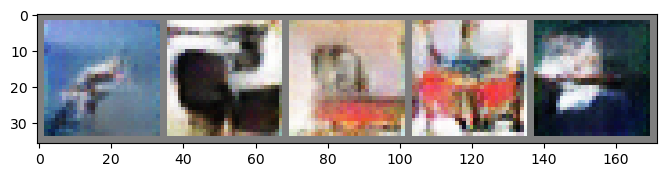

In [ ]:
#start training
training_condition(D, G, criterion, opt_d, opt_g, latent_dim, training_data, n_epoch=20, n_critic=1, model_type='CNN')

#### Predict

In [ ]:
def generate_condition_img(G, latent_dim, device,num_class=10, number_img=100, model_type='CNN'):
    #random z
    if model_type == 'MLP':
        z = torch.randn(number_img, latent_dim+num_class).to(device)
    elif model_type == 'CNN':
        z = torch.randn(number_img, latent_dim+num_class, 1, 1).to(device)
    # fake images
    c = np.asarray([random.randint(0,num_class-1) for i in range(number_img)], dtype=np.int32)
    onehot = torch.eye(num_class)[c].to(device)[:,:,None,None]
    z[:, :num_class] = onehot
    fake_x = G(z)
    gen_img = fake_x.detach().cpu()
    gen_img = gen_img.reshape(-1, 3, 32, 32)
    return gen_img

In [ ]:
#load model generating
G.load_state_dict(torch.load("CNN_Condition_G_0020.pt"))
gen_img = generate_condition_img(G, latent_dim, device, number_img=100, model_type='CNN')

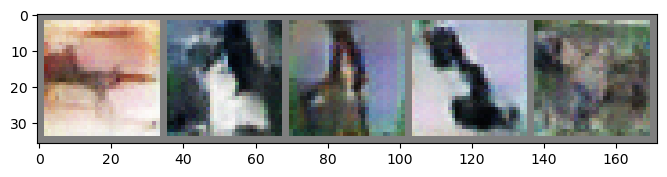

In [ ]:
#visualize generate image
num_show = 5
imshow(make_grid(gen_img[:num_show]))

**Conditional DC-GAN show better results compared with MLP-GAN but the result is not good as DC-GAN.**

### Cycle-GAN

In [ ]:
# create dataset for CIFAR10
class CustomCIFAR10(Dataset):
    def __init__(self, transform_a, transform_b):
        self.transform_a = transform_a
        self.transform_b = transform_b
        self.cifar = CIFAR10(root='./data', train=True, download=True)
    
    def __len__(self):
        return len(self.cifar)
    
    def __getitem__(self, idx):
        image_a = self.cifar[idx][0]
        image_b = self.cifar[idx][0]
        image_a = self.transform_a(image_a)
        image_b = self.transform_b(image_b)
        return image_a, image_b

In [ ]:
#transform data
transform_a = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_b = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
cycle_train_data = CustomCIFAR10(transform_a, transform_b)
cycle_training_data  = DataLoader(cycle_train_data, batch_size=batch_size, shuffle=True, num_workers= num_workers)

Files already downloaded and verified


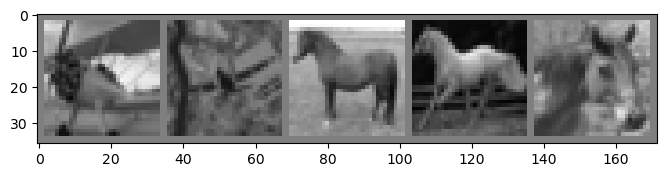

In [ ]:
# get some random training images
dataiter = iter(cycle_training_data)
images_a, images_b = next(iter(cycle_training_data))

# show images source
num_show = 5
imshow(make_grid(images_a[:num_show]))

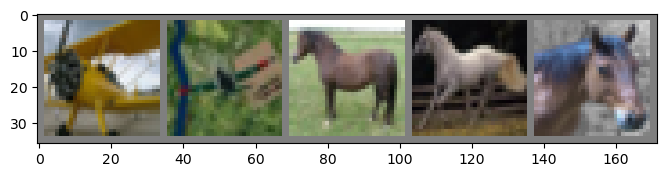

In [ ]:
# show images dest
num_show = 5
imshow(make_grid(images_b[:num_show]))

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, features):
        super(ResBlock, self).__init__()
        block_list = []
        self.block = self.make_block(block_list, features)
        
    def make_block(self, modules_list, features):
        modules_list.append(nn.ReflectionPad2d(1))
        modules_list.append(nn.Conv2d(features, features, kernel_size=3, stride=1, bias=True))
        modules_list.append(self.select_normalization(norm='instance', features=features))
        modules_list.append(nn.ReLU(inplace=True))
        modules_list.append(nn.ReflectionPad2d(1))
        modules_list.append(nn.Conv2d(features, features, kernel_size=3, stride=1, bias=True))
        modules_list.append(self.select_normalization(norm='instance', features=features))
        modules = nn.Sequential(*modules_list)
        return modules
        
    def select_normalization(self, norm, features):
        if norm == 'batch':
            return nn.BatchNorm2d(features)
        elif norm == 'instance':
            return nn.InstanceNorm2d(features)
        else:
            assert 0, '%s is not supported.' % norm

    def forward(self, x):
        out = x + self.block(x)
        return out

#### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_down, n_up, n_res, in_features):
        super(Generator, self).__init__()
        
        out_features = 64
        first_conv = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, out_features, kernel_size=7, stride=1, padding=0, bias=True),
            self.select_normalization(norm='instance', features=out_features),
            nn.ReLU(inplace=True)]
        
        down_block = []
        for _ in range(n_down):
            in_features = out_features
            out_features = in_features * 2
            down_block += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1, bias=True),
                self.select_normalization(norm='instance', features=out_features),
                nn.ReLU(inplace=True)]
            
        res_block = []
        res_features = out_features
        for _ in range(n_res):
            res_block.append(ResBlock(res_features))
            
        up_block = []
        in_features = res_features
        out_features = in_features // 2
        for _ in range(n_up):
            up_block += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                self.select_normalization(norm='instance', features=out_features),
                nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2
        
        last_conv = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, 3, kernel_size=7, stride=1, padding=0, bias=True),
            nn.Tanh()]
        
        self.first_conv = nn.Sequential(*first_conv)
        self.down_block = nn.Sequential(*down_block)
        self.res_block = nn.Sequential(*res_block)
        self.up_block = nn.Sequential(*up_block)
        self.last_conv = nn.Sequential(*last_conv)
        self.init_weights(self.first_conv)
        self.init_weights(self.down_block)
        self.init_weights(self.res_block)
        self.init_weights(self.up_block)
        self.init_weights(self.last_conv)

    def init_weights(self, net):
        classname = net.__class__.__name__
        if classname.find('Conv') != -1:
            torch.nn.init.normal_(net.weight.data, 0.0, 0.02)
            if hasattr(net, 'bias') and net.bias is not None:
                torch.nn.init.constant_(net.bias.data, 0.0)
    
    def select_normalization(self, norm, features):
        if norm == 'batch':
            return nn.BatchNorm2d(features)
        elif norm == 'instance':
            return nn.InstanceNorm2d(features)
        else:
            assert 0, '%s is not supported.' % norm
            
    def forward(self, x):
        h = self.first_conv(x)
        h = self.down_block(h)
        h = self.res_block(h)
        h = self.up_block(h)
        out = self.last_conv(h)   
        return out

#### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_layers=3):
        super(Discriminator, self).__init__()
        out_features = 64
        modules = [nn.Conv2d(3, out_features, kernel_size=4, stride=2, padding=1, bias=True),
                   nn.LeakyReLU(negative_slope=0.2, inplace=True)]

        for i in range(n_layers):
            in_features = out_features
            out_features = in_features * 2
            if i == n_layers - 1:    stride=1
            else:    stride=2
            modules += [nn.Conv2d(in_features, out_features, kernel_size=4, stride=stride, padding=1, bias=True),
                        self.select_normalization(norm='instance', features=out_features),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True)]
        
        modules += [nn.Conv2d(out_features, 1, kernel_size=4, stride=1, padding=1, bias=True)]
        self.layers = nn.Sequential(*modules)
        self.init_weights(self.layers)

    def init_weights(self, net):
        classname = net.__class__.__name__
        if classname.find('Conv') != -1:
            torch.nn.init.normal_(net.weight.data, 0.0, 0.02)
            if hasattr(net, 'bias') and net.bias is not None:
                torch.nn.init.constant_(net.bias.data, 0.0)
    
    def select_normalization(self, norm, features):
        if norm == 'batch':
            return nn.BatchNorm2d(features)
        elif norm == 'instance':
            return nn.InstanceNorm2d(features)
        else:
            assert 0, '%s is not supported.' % norm
            
    def forward(self, x):
        out = self.layers(x)
        return out

#### Training function

In [ ]:
class Image_History_Buffer:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.buffer = []
    
    def get_images(self,pre_images):
        return_imgs = []
        for img in pre_images:
            img = torch.unsqueeze(img,0)
            if len(self.buffer) < self.pool_size:
                self.buffer.append(img)
                return_imgs.append(img)
            else:
                if random.randint(0,1)>0.5:
                    i = random.randint(0,self.pool_size-1)
                    tmp = self.buffer[i].clone()
                    self.buffer[i]=img
                    return_imgs.append(tmp)
                else:
                    return_imgs.append(img)
        return torch.cat(return_imgs,dim=0)

In [ ]:
class loss_scheduler():
    def __init__(self, epoch_decay):
        self.epoch_decay = epoch_decay

    def f(self, epoch):
        if epoch<=self.epoch_decay:
            return 1
        else:
            scaling = 1 - (epoch-self.epoch_decay)/float(self.epoch_decay)
            return scaling

In [ ]:
import itertools
# Define networks
G_A2B = Generator(n_down=2, n_up=2, n_res=9, in_features=3).to(device)
G_B2A = Generator(n_down=2, n_up=2, n_res=9, in_features=3).to(device)
D_A = Discriminator(n_layers=3).to(device)
D_B = Discriminator(n_layers=3).to(device)

g_opt = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=learning_rate, betas=(0.5, 0.999))
d_A_opt = optim.Adam(D_A.parameters(), lr=learning_rate, betas=(0.5, 0.999))
d_B_opt = optim.Adam(D_B.parameters(), lr=learning_rate, betas=(0.5, 0.999))

g_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(g_opt, lr_lambda=loss_scheduler(100).f)
d_a_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(d_A_opt, lr_lambda=loss_scheduler(100).f)
d_b_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(d_B_opt, lr_lambda=loss_scheduler(100).f)

adv_loss = nn.MSELoss()
l1_norm = nn.L1Loss()
criterion_idn = nn.L1Loss()

buffer_for_fakeA = Image_History_Buffer()
buffer_for_fakeB = Image_History_Buffer()

In [ ]:
def training_cycle(G_B2A, G_A2B, D_A, D_B, g_opt, opt_d, d_A_opt, d_B_opt, adv_loss, l1_norm, criterion_idn, training_dataset, lambda_val=10, n_epochs=20, freq_save=5):
    for epoch in range(1, n_epochs+1):
        G_B2A.train()
        G_A2B.train()
        D_A.train()
        D_B.train()
        for idx, (imgA, imgB) in enumerate(training_dataset):
            imgA = torch.autograd.Variable(imgA.to(device), requires_grad=True)
            imgB = torch.autograd.Variable(imgB.to(device), requires_grad=True)
            imgA_fake = G_B2A(imgB) 
            imgB_fake = G_A2B(imgA)
            imgA_rec, imgB_rec = G_B2A(imgB_fake), G_A2B(imgA_fake)
   
            d_A_opt.zero_grad()
            disA_out_real = D_A(imgA)
            imgA_fake_ = buffer_for_fakeA.get_images(imgA_fake)
            disA_out_fake = D_A(imgA_fake_.detach())
            d_lossA_real = adv_loss(disA_out_real, torch.tensor(1.0).expand_as(disA_out_real).to(device))
            d_lossA_fake = adv_loss(disA_out_fake, torch.tensor(0.0).expand_as(disA_out_fake).to(device))
            disA_loss = (d_lossA_real + d_lossA_fake) * 0.5
            disA_loss.backward()
            d_A_opt.step()

            d_B_opt.zero_grad()
            disB_out_real = D_B(imgB)
            imgB_fake_ = buffer_for_fakeB.get_images(imgB_fake)
            disB_out_fake = D_B(imgB_fake_.detach())
            d_lossB_real = adv_loss(disB_out_real, torch.tensor(1.0).expand_as(disB_out_real).to(device))
            d_lossB_fake = adv_loss(disB_out_fake, torch.tensor(0.0).expand_as(disA_out_fake).to(device))
            disB_loss = (d_lossB_real + d_lossB_fake) * 0.5
            disB_loss.backward()
            d_B_opt.step()

            # Update the generator (G)
            g_opt.zero_grad()
            disB_out_fake = D_B(imgB_fake)
            disA_out_fake = D_A(imgA_fake)
            g_lossA = adv_loss(disA_out_fake, torch.tensor(1.0).expand_as(disA_out_fake).to(device))
            g_lossB = adv_loss(disB_out_fake, torch.tensor(1.0).expand_as(disB_out_fake).to(device))
            gen_adv_loss = g_lossA + g_lossB

            cycle_consistency_loss = l1_norm(imgA_rec, imgA) + l1_norm(imgB_rec, imgB)
     
            gen_loss = gen_adv_loss + lambda_val * cycle_consistency_loss
            gen_loss.backward()
            g_opt.step()
        # imgB_fake
        print('Epoch: {:02} | D loss (A): {:.6f} | D loss (B): {:.6f} | G loss: {:.6f} | Consistency: {:.6f} |'\
              .format(epoch, disA_loss.item(), disB_loss.item(), gen_loss.item(), cycle_consistency_loss.item()))
        mean = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)[None,:,None,None].to(device)
        std = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32)[None,:,None,None].to(device)
        #save weights
        if (epoch % freq_save == 0) or (epoch == 1):
            #save model
            torch.save(G_B2A.state_dict(), "Cycle_G_B2A_%04d.pt" % epoch)
            torch.save(G_A2B.state_dict(), "Cycle_G_A2B_%04d.pt" % epoch)
            torch.save(D_A.state_dict(), "Cycle_D_A_%04d.pt" % epoch)
            torch.save(D_B.state_dict(), "Cycle_D_B_%04d.pt" % epoch)
            # visualize image A
            imgA_real = (imgA * std) + mean
            real_img = imgA_real.detach().cpu()
            real_img = real_img.reshape(-1, 3, 32, 32)
            imshow(make_grid(real_img[:5]))
            #image generate from image  A
            imgB_fake = (imgB_fake * std) + mean
            gen_img = imgB_fake.detach().cpu()
            gen_img = gen_img.reshape(-1, 3, 32, 32)
            imshow(make_grid(gen_img[:5]))

Epoch: 01 | D loss (A): 0.195687 | D loss (B): 0.046812 | G loss: 2.785887 | Consistency: 0.189132 |


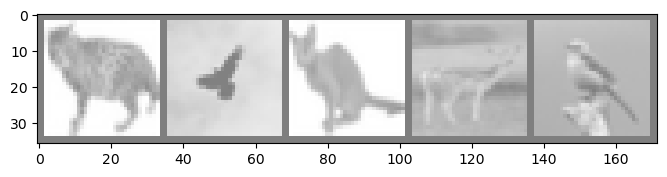

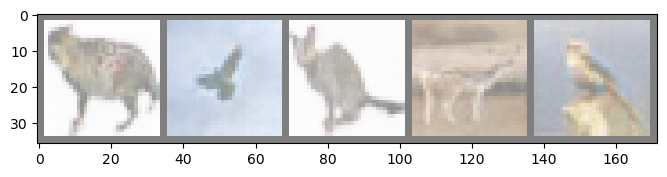

Epoch: 02 | D loss (A): 0.000898 | D loss (B): 0.048222 | G loss: 4.421986 | Consistency: 0.203591 |
Epoch: 03 | D loss (A): 0.019099 | D loss (B): 0.070686 | G loss: 4.278021 | Consistency: 0.208942 |
Epoch: 04 | D loss (A): 0.001299 | D loss (B): 0.059335 | G loss: 3.564825 | Consistency: 0.195505 |
Epoch: 05 | D loss (A): 0.000034 | D loss (B): 0.075043 | G loss: 3.986195 | Consistency: 0.195103 |


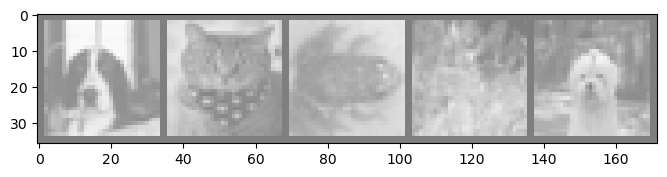

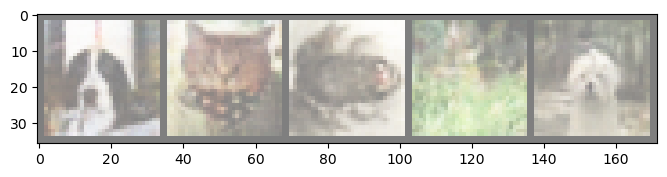

Epoch: 06 | D loss (A): 0.000263 | D loss (B): 0.109112 | G loss: 4.416480 | Consistency: 0.186738 |
Epoch: 07 | D loss (A): 0.000103 | D loss (B): 0.068985 | G loss: 4.022033 | Consistency: 0.204632 |
Epoch: 08 | D loss (A): 0.000092 | D loss (B): 0.029047 | G loss: 3.855639 | Consistency: 0.193860 |
Epoch: 09 | D loss (A): 0.000490 | D loss (B): 0.040607 | G loss: 3.985296 | Consistency: 0.180358 |
Epoch: 10 | D loss (A): 0.000131 | D loss (B): 0.065487 | G loss: 4.474211 | Consistency: 0.203697 |


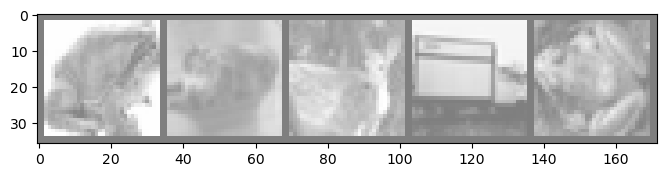

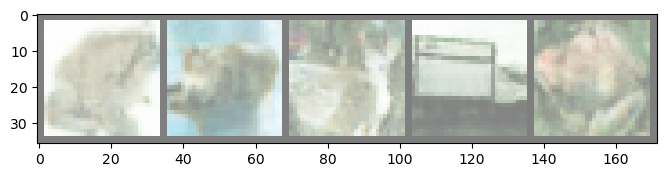

Epoch: 11 | D loss (A): 0.000063 | D loss (B): 0.066187 | G loss: 3.839917 | Consistency: 0.168257 |
Epoch: 12 | D loss (A): 0.001245 | D loss (B): 0.105034 | G loss: 3.586901 | Consistency: 0.175566 |
Epoch: 13 | D loss (A): 0.000112 | D loss (B): 0.047922 | G loss: 3.922706 | Consistency: 0.198860 |
Epoch: 14 | D loss (A): 0.001405 | D loss (B): 0.113605 | G loss: 2.874945 | Consistency: 0.168494 |
Epoch: 15 | D loss (A): 0.000532 | D loss (B): 0.078052 | G loss: 3.683669 | Consistency: 0.181038 |


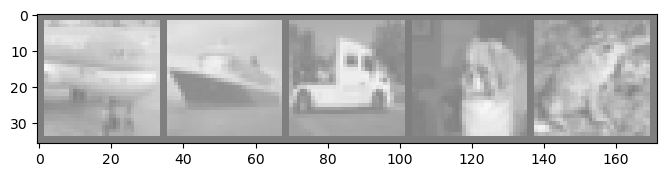

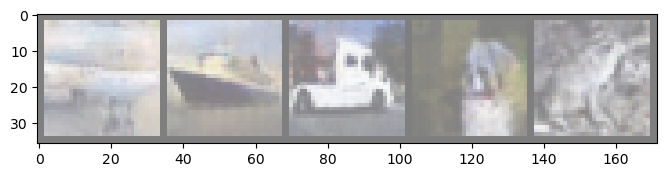

Epoch: 16 | D loss (A): 0.001328 | D loss (B): 0.047557 | G loss: 3.631893 | Consistency: 0.175162 |
Epoch: 17 | D loss (A): 0.000075 | D loss (B): 0.030246 | G loss: 4.005678 | Consistency: 0.169630 |
Epoch: 18 | D loss (A): 0.000258 | D loss (B): 0.038137 | G loss: 3.901859 | Consistency: 0.163479 |
Epoch: 19 | D loss (A): 0.000701 | D loss (B): 0.052387 | G loss: 3.664880 | Consistency: 0.159150 |
Epoch: 20 | D loss (A): 0.000173 | D loss (B): 0.044138 | G loss: 3.231086 | Consistency: 0.155710 |


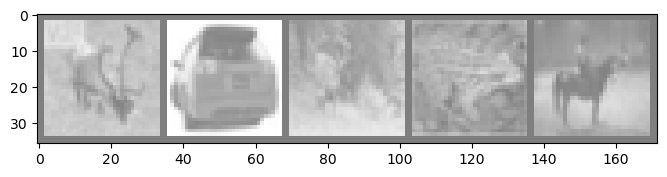

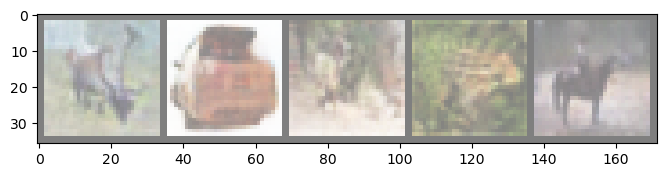

In [ ]:
training_cycle(G_B2A, G_A2B, D_A, D_B, g_opt, opt_d, d_A_opt, d_B_opt, adv_loss, l1_norm, criterion_idn, cycle_training_data, n_epochs=20, freq_save=5)

#### Predict

In [ ]:
def generate_cycle_img(G_A2B, training_dataset, device, number_img=100):
    G_A2B.eval()
    total_pred = None
    for idx, (imgA, _) in enumerate(training_dataset):
        imgA = torch.autograd.Variable(imgA.to(device), requires_grad=True)
        imgB_fake = G_A2B(imgA)
        gen_img = imgB_fake.detach().cpu()
        gen_img = gen_img.reshape(-1, 3, 32, 32)
        if idx == 0:
            total_pred = gen_img
        elif idx == number_img:
            break
        else:
            total_pred = np.concatenate((total_pred, gen_img), axis=0)
        
    return torch.tensor(total_pred)

In [ ]:
#load model generating
G_A2B.load_state_dict(torch.load("Cycle_G_A2B_0020.pt"))
gen_img = generate_cycle_img(G_A2B, cycle_training_data, device)

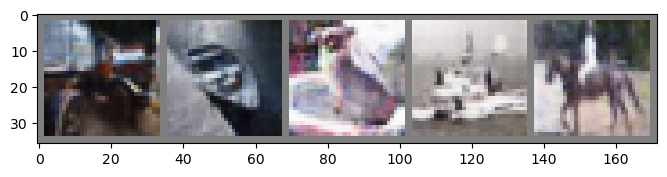

In [ ]:
#visualize generate image
num_show = 5
imshow(make_grid(gen_img[:num_show]))

**Cycle GAN with different approachs compare with DCGAN or ConditionalGAN, it shows very good result.**

**Conclusion**:  

1.   **DC-GAN is better than MLP-GAN, Conditional-GAN can use to improve for both DC-GAN and MLP-GAN.**
2.   **Cycle-GAN is very good approach to learn style from a image and apply to other image.**


### Future Imporvement



1.   Apply other SOTA GAN architecture: Style-GAN, BIG-GAN..
2.   Training GAN with high-resolution: (512, 512) or (1024, 1024)

